# **Using Dice loss only**

In [1]:
!pip install "protobuf<5" -q

In [2]:
!pip install monai-weekly --no-deps -q
!pip install einops -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.1 MB/s eta 0:00:00


In [3]:
import os
import gc
import cv2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import nibabel as nib
import csv
import time 
from datetime import datetime
import warnings
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from monai.networks.nets import UNet
from monai.metrics import HausdorffDistanceMetric
from monai.transforms import AsDiscrete
from monai.losses import DiceLoss

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-02 07:02:14.695340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764658934.937280      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764658935.006186      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
class Config:

    train_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr'
    labels_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr'
    outputs_dir = "/kaggle/working/outputs"

    vol_paths = list()
    seg_paths = list()

    n_classes = 1
    vols_count = None
    segs_count = None

    window = (-30,140)

    num_epochs = 40
    batch_size = 16
    lr = 0.0001

    height, width = 256, 256
    
config = Config()

In [7]:
for file in os.listdir(Config.train_dir):
    if file.endswith('.nii'):

        Config.vol_paths.append(os.path.join(Config.train_dir,file))
        Config.seg_paths.append(os.path.join(Config.labels_dir,file))

Config.vols_count = len(Config.vol_paths)
Config.segs_count = len(Config.seg_paths)

print('Total CT Scan Volumes for Train:', Config.vols_count)
print('Total Segmentation masks:', Config.segs_count)

Total CT Scan Volumes for Train: 123
Total Segmentation masks: 123


In [8]:
path = Config.vol_paths[1]
data = nib.load(path).get_fdata().transpose(2,1,0)
seg = nib.load(Config.seg_paths[1]).get_fdata().transpose(2,1,0)

In [9]:
seg.shape

(183, 210, 210)

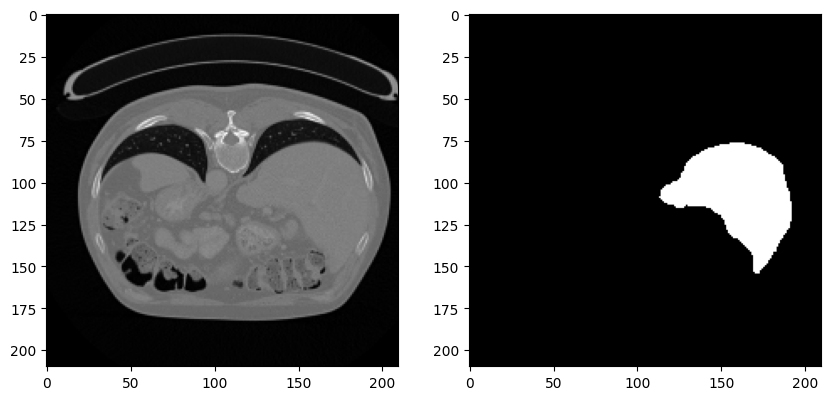

In [10]:
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(seg[150], cmap = 'gray')
plt.show()

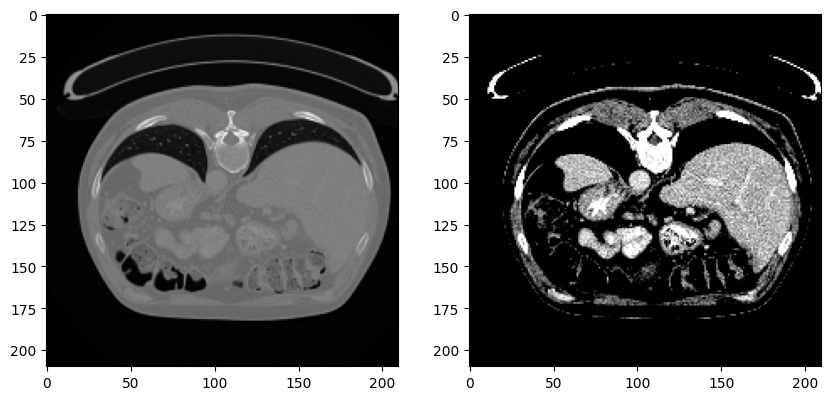

In [11]:
win_img = np.clip(data[150], -30,140)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

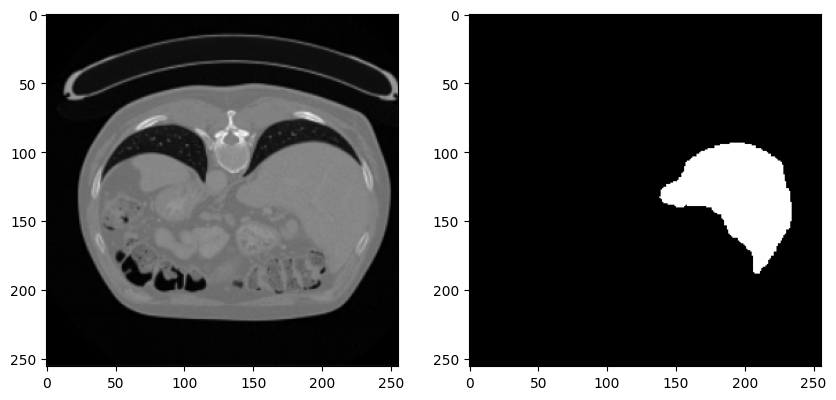

In [12]:
resized_X = resize(data[150], (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
resized_Y = resize(seg[150], (256, 256), mode='constant', preserve_range=True, order=0)

_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(resized_X, cmap = 'gray')
axes[1].imshow(resized_Y, cmap = 'gray')
plt.show()

In [13]:
def preprocess(ct_scan: np.ndarray, window: tuple = Config.window) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    # Apply windowing
    windowed_ct = np.clip(ct_scan, min_value, max_value)

    # Normalize to 0-1
    windowed_ct = ((windowed_ct - min_value) / (max_value - min_value))

    return windowed_ct

In [14]:
height, width = Config.height, Config.width
train_transform = A.Compose([
    A.Resize(height=height, width=width,interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.20, p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),


], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(height=Config.height, width=Config.width)
])

In [15]:
dataset = None

if dataset is not None:
    dataset = pd.DataFrame(dataset, columns = ['slice_idx', 'liver_mask_exists', 'vol_path', 'seg_path'])
    dataset.to_csv('liver-path-data.csv', index= False)
else:
    dataset = pd.read_csv('/kaggle/input/liver-path-data/liver-path-data.csv')
dataset.head()

,slice_idx,liver_mask_exists,vol_path,seg_path
0,0,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
1,1,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
2,2,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
3,3,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
4,4,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...


In [16]:
print("Total CT slices: ", len(dataset))
print("Slices with Liver: ", sum(dataset.liver_mask_exists))

Total CT slices:  19604
Slices with Liver:  6413


In [17]:
class LiverDataset(Dataset):
    def __init__(self, data, transform=None, preprocess_fn=None):
        self.slice_data = data
        self.transform = transform
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):

        slice_idx, _, vol_path, seg_path = self.slice_data.iloc[idx]

        # Load volume and mask
        vol = nib.load(vol_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        # Extract slice
        X = vol[:, :, slice_idx].transpose(1,0)
        Y = (seg[:, :, slice_idx].transpose(1,0) > 0).astype(np.float32)

        # 1. Apply your windowing + normalization
        if self.preprocess_fn:
            X = self.preprocess_fn(X)

        # 2. Albumentations expects HWC
        X = np.expand_dims(X, axis=-1)
        Y = np.expand_dims(Y, axis=-1)

        # 3. Augmentation (train) or Resize only (val)
        if self.transform:
            augmented = self.transform(image=X, mask=Y)
            X = augmented["image"]
            Y = augmented["mask"]

        # 4. Convert to CHW
        X = np.transpose(X, (2,0,1))
        Y = np.transpose(Y, (2,0,1))

        # 5. To torch
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()

        return X, Y

In [18]:
train, test = train_test_split(dataset,test_size=0.3, random_state=42, stratify=dataset.liver_mask_exists)


train_dataset = LiverDataset(train, transform=train_transform, preprocess_fn=preprocess)
val_dataset = LiverDataset(test,transform=val_transform, preprocess_fn=preprocess)


train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True,num_workers=4, pin_memory=True )
val_dataloader   = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers = 2, pin_memory = True)


Displaying 5 raw vs processed samples...



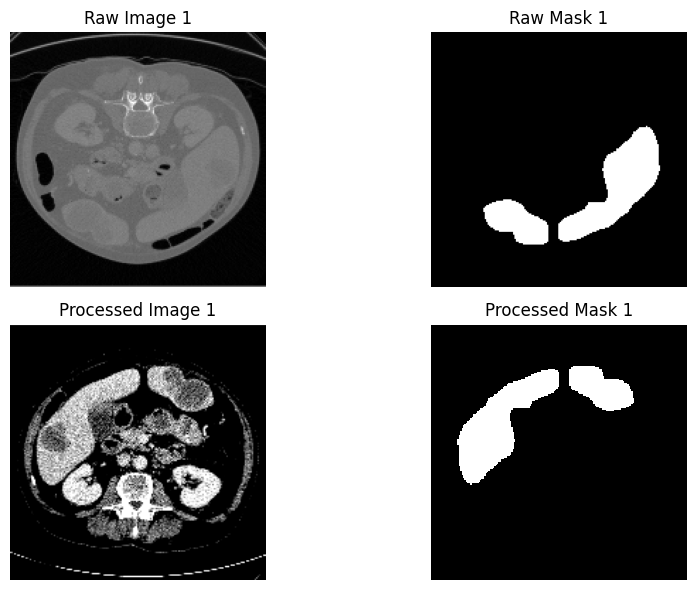

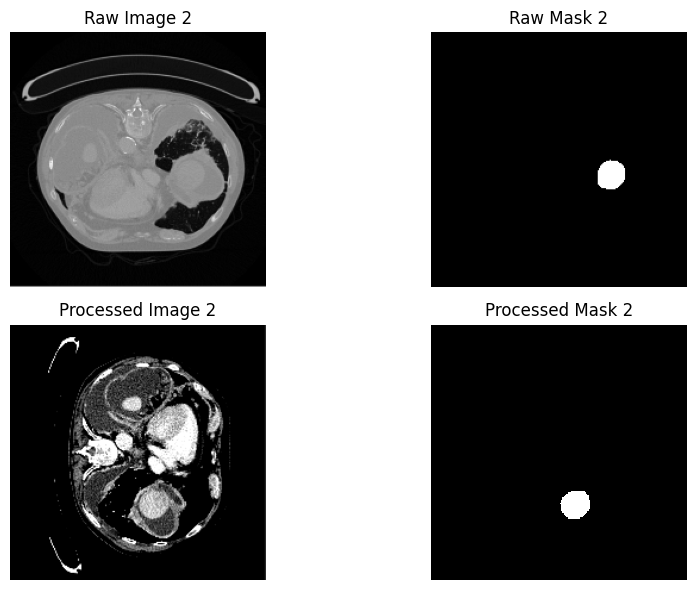

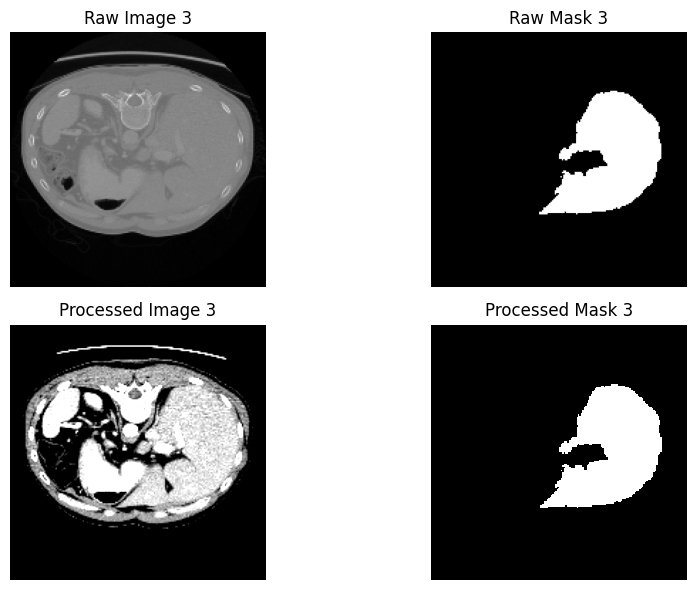

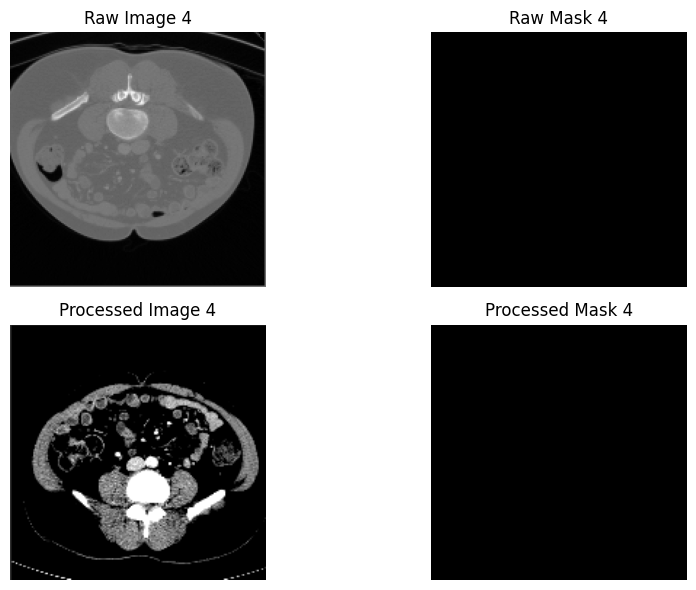

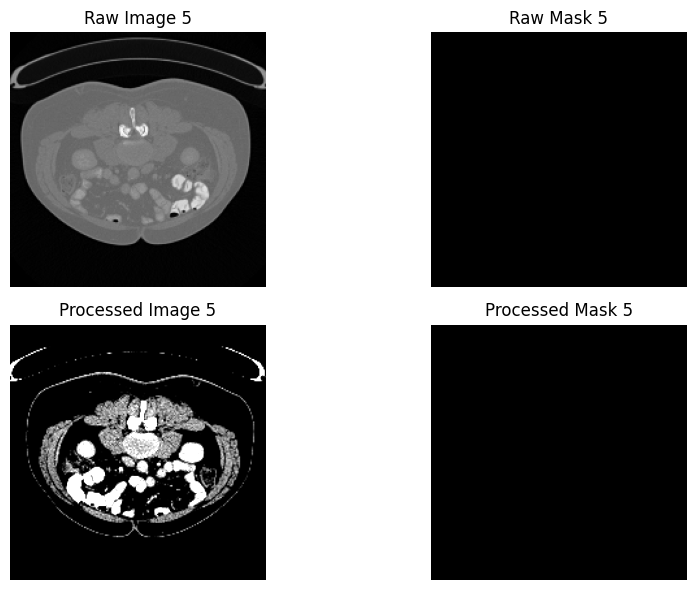

In [19]:
#Visulaize the effect of pre-processing 

def load_raw_slice(sample_row):
    slice_idx, _, vol_path, seg_path = sample_row

    # Load volume and segmentation
    vol = nib.load(vol_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    # Extract 2D slice
    X_raw = vol[:, :, slice_idx].transpose(1, 0)
    Y_raw = (seg[:, :, slice_idx].transpose(1, 0) > 0).astype(np.float32)

    return X_raw, Y_raw

def visualize_sample(raw_img, raw_mask, proc_img, proc_mask, index):
    plt.figure(figsize=(10, 6))

    # Raw Image
    plt.subplot(2, 2, 1)
    plt.imshow(raw_img, cmap='gray')
    plt.title(f"Raw Image {index}")
    plt.axis("off")

    # Raw Mask
    plt.subplot(2, 2, 2)
    plt.imshow(raw_mask, cmap='gray')
    plt.title(f"Raw Mask {index}")
    plt.axis("off")

    # Processed (augmented) Image
    plt.subplot(2, 2, 3)
    plt.imshow(proc_img.squeeze(), cmap='gray')
    plt.title(f"Processed Image {index}")
    plt.axis("off")

    # Processed (augmented) Mask
    plt.subplot(2, 2, 4)
    plt.imshow(proc_mask.squeeze(), cmap='gray')
    plt.title(f"Processed Mask {index}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

num_samples = 5
print("\nDisplaying 5 raw vs processed samples...\n")

for i in range(num_samples):
    # Get the i-th row from your training dataframe
    sample_row = train.iloc[i]

    # ---- 1. RAW DATA ----
    raw_img, raw_mask = load_raw_slice(sample_row)

    # ---- 2. PROCESSED (preprocessed + augmented) ----
    proc_img, proc_mask = train_dataset[i]   # returns CHW tensors

    # Convert processed images to numpy & HWC
    proc_img = proc_img.numpy().transpose(1, 2, 0)
    proc_mask = proc_mask.numpy().transpose(1, 2, 0)

    # ---- VISUALIZE ----
    visualize_sample(raw_img, raw_mask, proc_img, proc_mask, i+1)

In [20]:
from monai.networks.nets import UNet

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2,2,2,2),
    num_res_units=2,
    act='PRELU',
    norm='INSTANCE',
    dropout=0.0,
    bias=True,
    adn_ordering='NDA'
).to(device)

In [21]:
from torchinfo import summary
summary(model, input_size=(1, 1, 256, 256), col_names=("input_size","output_size","num_params","trainable"), device=str(device))

Layer (type:depth-idx)                                                                     Input Shape               Output Shape              Param #                   Trainable
UNet                                                                                       [1, 1, 256, 256]          [1, 1, 256, 256]          --                        True
├─Sequential: 1-1                                                                          [1, 1, 256, 256]          [1, 1, 256, 256]          --                        True
│    └─ResidualUnit: 2-1                                                                   [1, 1, 256, 256]          [1, 32, 128, 128]         --                        True
│    │    └─Conv2d: 3-1                                                                    [1, 1, 256, 256]          [1, 32, 128, 128]         320                       True
│    │    └─Sequential: 3-2                                                                [1, 1, 256, 256]          [1, 32, 

In [22]:
def compute_metrics(outputs, targets, threshold=0.5, eps=1e-7):
    """
    Returns soft-thresholded Dice, IoU, Precision, Recall (floats).
    outputs: raw logits (Tensor Bx1xHxW)
    targets: binary masks  (Tensor Bx1xHxW)
    """
    probs       = torch.sigmoid(outputs)
    preds       = (probs > threshold).float()
    t_flat      = targets.view(targets.size(0), -1)
    p_flat      = preds.view(preds.size(0), -1)

    tp    = (p_flat * t_flat).sum(dim=1)
    fp    = p_flat.sum(dim=1) - tp
    fn    = t_flat.sum(dim=1) - tp

    dice  = (2*tp + eps) / (p_flat.sum(1) + t_flat.sum(1) + eps)
    iou   = (tp + eps)   / (p_flat.sum(1) + t_flat.sum(1) - tp + eps)
    prec  = (tp + eps)   / (tp + fp + eps)
    rec   = (tp + eps)   / (tp + fn + eps)

    return dice.mean().item(), iou.mean().item(), prec.mean().item(), rec.mean().item()

def compute_hausdorff(outputs, targets, threshold=0.5, percentile=95):
    """
    Returns mean Hausdorff Distance over the batch.
    outputs: raw logits (Tensor Bx1xHxW)
    targets: binary masks  (Tensor Bx1xHxW)
    """
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    hd_metric = HausdorffDistanceMetric(include_background=False, percentile=percentile)
    # hd_metric accepts batch‐first torch.Tensors directly
    hd_vals = hd_metric(preds, targets)
    # hd_vals is Tensor of shape (B,)
    return float(torch.nanmean(hd_vals).item())

In [23]:
inputs, masks = next(iter(train_dataloader))
inputs = inputs.to(device)
outputs = model(inputs)
print(inputs.shape, outputs.shape, masks.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


In [24]:
criterion_dice = DiceLoss(include_background=False, to_onehot_y=False, sigmoid=True)
patience = 20
# add weight decay to the optimizer
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode = 'min',
    factor=0.5       
)

In [25]:
class Trainer:

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 optimizer,
                 scheduler,
                 device,
                 criterion_dice,
                 compute_metrics,
                 compute_hausdorff,
                 csv_path="training_log.csv",
                 checkpoint_path="best_model.pth",
                 patience=10):

        # Core components
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        # Loss & metric functions
        self.criterion_dice = criterion_dice
        self.compute_metrics = compute_metrics
        self.compute_hausdorff = compute_hausdorff

        # Logging
        self.csv_path = csv_path
        self.checkpoint_path = checkpoint_path
        self.patience = patience

        # Tracking
        self.best_val_loss = float('inf')
        self.patience_counter = 0

        # CSV header
        self.fields = [
            "epoch", "time",
            "train_loss", "val_loss",
            "dice_train", "dice_val",
            "iou_train", "iou_val",
            "precision_train", "precision_val",
            "recall_train", "recall_val",
            "hd_train", "hd_val",
            "lr"
        ]

        self._create_csv()


    def _create_csv(self):
        with open(self.csv_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=self.fields)
            writer.writeheader()

    def _append_csv(self, row_dict):
        with open(self.csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=self.fields)
            writer.writerow(row_dict)

    # ---------------------------------------------------
    # TRAIN ONE EPOCH
    # ---------------------------------------------------
    def _train_one_epoch(self, epoch):

        import math

        self.model.train()
        t_loss = t_dice = t_iou = t_prec = t_rec = 0.0
        t_hd = 0.0  # accumulate batch-wise HD95

        train_iter = tqdm(enumerate(self.train_loader),
                          total=len(self.train_loader),
                          desc=f"Epoch {epoch} [Train]")

        for i, (data, labels) in train_iter:

            data = data.to(self.device)
            labels = labels.to(self.device).float()

            self.optimizer.zero_grad()

            outputs = self.model(data)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[-1]

            loss = self.criterion_dice(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # Loss accumulation
            t_loss += loss.item()

            # GPU metrics (Dice/IoU/Prec/Rec)
            b_dice, b_iou, b_prec, b_rec = self.compute_metrics(
                outputs.detach(), labels.detach()
            )

            t_dice += b_dice
            t_iou  += b_iou
            t_prec += b_prec
            t_rec  += b_rec

            # Compute batch HD95 on CPU and accumulate (constant memory)
            try:
                batch_hd = self.compute_hausdorff(outputs.detach().cpu(), labels.detach().cpu())
            except Exception:
                # In case the metric function errors for this batch, treat as 0
                batch_hd = 0.0

            # Guard against NaN/inf: treat as 0 (empty masks -> correct prediction)
            if not isinstance(batch_hd, float) or not math.isfinite(batch_hd):
                batch_hd = 0.0

            t_hd += batch_hd

            # update progress (show averaged metrics so far)
            train_iter.set_postfix({
                "loss": f"{t_loss/(i+1):.4f}",
                "dice": f"{t_dice/(i+1):.4f}",
                "iou": f"{t_iou/(i+1):.4f}",
                "prec": f"{t_prec/(i+1):.4f}",
                "rec": f"{t_rec/(i+1):.4f}",
                "hd":   f"{(t_hd/(i+1)):.4f}"
            })

        n = len(self.train_loader)
        hd_train = t_hd / n if n > 0 else 0.0
        return (t_loss/n, t_dice/n, t_iou/n, t_prec/n, t_rec/n, hd_train)

    # ---------------------------------------------------
    # VALIDATION
    # ---------------------------------------------------
    def _validate(self, epoch):

        import math

        self.model.eval()
        v_loss = v_dice = v_iou = v_prec = v_rec = 0.0
        v_hd = 0.0

        val_iter = tqdm(enumerate(self.val_loader),
                        total=len(self.val_loader),
                        desc=f"Epoch {epoch} [Val]")

        with torch.no_grad():
            for i, (data, labels) in val_iter:

                data = data.to(self.device)
                if labels.ndim == 3:
                    labels = labels.unsqueeze(1)
                labels = labels.to(self.device).float()

                outputs = self.model(data)
                if isinstance(outputs, (list, tuple)):
                    outputs = outputs[-1]

                loss = self.criterion_dice(outputs, labels)

                v_loss += loss.item()

                # GPU metrics
                b_dice, b_iou, b_prec, b_rec = self.compute_metrics(
                    outputs.detach(), labels.detach()
                )

                v_dice += b_dice
                v_iou  += b_iou
                v_prec += b_prec
                v_rec  += b_rec

                # batch-wise HD95 on CPU
                try:
                    batch_hd = self.compute_hausdorff(outputs.detach().cpu(), labels.detach().cpu())
                except Exception:
                    batch_hd = 0.0

                if not isinstance(batch_hd, float) or not math.isfinite(batch_hd):
                    batch_hd = 0.0

                v_hd += batch_hd

                val_iter.set_postfix({
                    "loss": f"{v_loss/(i+1):.4f}",
                    "dice": f"{v_dice/(i+1):.4f}",
                    "iou": f"{v_iou/(i+1):.4f}",
                    "prec": f"{v_prec/(i+1):.4f}",
                    "rec": f"{v_rec/(i+1):.4f}",
                    "hd":   f"{(v_hd/(i+1)):.4f}"
                })

        n = len(self.val_loader)
        hd_val = v_hd / n if n > 0 else 0.0
        return (v_loss/n, v_dice/n, v_iou/n, v_prec/n, v_rec/n, hd_val)

    # ---------------------------------------------------
    # MAIN TRAIN FUNCTION
    # ---------------------------------------------------
    def fit(self, num_epochs):

        total_time = 0

        for epoch in range(1, num_epochs+1):

            print(f"\n========== Epoch {epoch}/{num_epochs} ==========")
            start = time.time()

            # ---- training ----
            train_loss, train_dice, train_iou, train_prec, train_rec, train_hd = \
                self._train_one_epoch(epoch)

            # ---- validation ----
            val_loss, val_dice, val_iou, val_prec, val_rec, val_hd = \
                self._validate(epoch)

            # ---- scheduler ----
            self.scheduler.step(val_loss)
            lr = self.optimizer.param_groups[0]["lr"]

            epoch_time = time.time() - start
            total_time += epoch_time

            print(
                f"Train Loss={train_loss:.4f} | Dice={train_dice:.4f}, IoU={train_iou:.4f}, "
                f"Prec={train_prec:.4f}, Rec={train_rec:.4f}, HD={train_hd:.4f}"
            )
            print(
                f"Val   Loss={val_loss:.4f} | Dice={val_dice:.4f}, IoU={val_iou:.4f}, "
                f"Prec={val_prec:.4f}, Rec={val_rec:.4f}, HD={val_hd:.4f}"
            )

            # ---- checkpoint ----
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                torch.save(self.model.state_dict(), self.checkpoint_path)
                print("  ↳ Best model updated")
            else:
                self.patience_counter += 1
                print(f"  ↳ No improvement for {self.patience_counter} epoch(s)")
                if self.patience_counter >= self.patience:
                    print("Early stopping activated!")
                    break

            # ---- log to CSV ----
            self._append_csv({
                "epoch": epoch,
                "time": round(epoch_time, 2),
                "train_loss": round(train_loss, 4),
                "val_loss": round(val_loss, 4),
                "dice_train": round(train_dice, 4),
                "dice_val": round(val_dice, 4),
                "iou_train": round(train_iou, 4),
                "iou_val": round(val_iou, 4),
                "precision_train": round(train_prec, 4),
                "precision_val": round(val_prec, 4),
                "recall_train": round(train_rec, 4),
                "recall_val": round(val_rec, 4),
                "hd_train": round(train_hd, 4),
                "hd_val": round(val_hd, 4),
                "lr": lr
            })

        print(f"\nTraining Completed! Total Time = {total_time:.2f}s")
        print(f"Best Validation Loss = {self.best_val_loss:.4f}")

In [26]:
trainer = Trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    criterion_dice=criterion_dice,
    compute_metrics=compute_metrics,
    compute_hausdorff=compute_hausdorff,
    csv_path="Unet_metrics.csv",
    checkpoint_path="Unet_best.pth",
    patience=20
)

trainer.fit(num_epochs=120)


========== Epoch 1/120 ==========


Epoch 1 [Train]:   0%|          | 0/858 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/losses/dice.py:175: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
Epoch 1 [Val]: 100%|██████████| 368/368 [01:35<00:00,  3.87it/s, loss=0.9198, dice=0.1907, iou=0.1542, prec=0.1550, rec=0.9902, hd=91.0938]


Train Loss=0.9262 | Dice=0.1698, IoU=0.1329, Prec=0.1336, Rec=0.9857, HD=101.6450
Val   Loss=0.9198 | Dice=0.1907, IoU=0.1542, Prec=0.1550, Rec=0.9902, HD=91.0938
  ↳ Best model updated

========== Epoch 2/120 ==========


Epoch 2 [Val]: 100%|██████████| 368/368 [01:32<00:00,  3.96it/s, loss=0.9097, dice=0.1844, iou=0.1464, prec=0.1469, rec=0.9931, hd=93.4552]


Train Loss=0.9166 | Dice=0.1901, IoU=0.1543, Prec=0.1552, Rec=0.9861, HD=82.0720
Val   Loss=0.9097 | Dice=0.1844, IoU=0.1464, Prec=0.1469, Rec=0.9931, HD=93.4552
  ↳ Best model updated

========== Epoch 3/120 ==========


Epoch 3 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.43it/s, loss=0.8946, dice=0.1997, iou=0.1647, prec=0.1657, rec=0.9861, hd=70.1166]

Train Loss=0.9043 | Dice=0.1909, IoU=0.1553, Prec=0.1562, Rec=0.9872, HD=79.0101
Val   Loss=0.8946 | Dice=0.1997, IoU=0.1647, Prec=0.1657, Rec=0.9861, HD=70.1166
  ↳ Best model updated

========== Epoch 4/120 ==========



Epoch 4 [Val]: 100%|██████████| 368/368 [01:09<00:00,  5.26it/s, loss=0.8768, dice=0.1991, iou=0.1646, prec=0.1654, rec=0.9895, hd=65.3248]

Train Loss=0.8882 | Dice=0.1931, IoU=0.1583, Prec=0.1593, Rec=0.9882, HD=76.9113
Val   Loss=0.8768 | Dice=0.1991, IoU=0.1646, Prec=0.1654, Rec=0.9895, HD=65.3248
  ↳ Best model updated

========== Epoch 5/120 ==========



Epoch 5 [Val]: 100%|██████████| 368/368 [01:32<00:00,  4.00it/s, loss=0.8580, dice=0.2060, iou=0.1728, prec=0.1742, rec=0.9941, hd=71.6192]

Train Loss=0.8704 | Dice=0.1984, IoU=0.1649, Prec=0.1661, Rec=0.9874, HD=73.4714
Val   Loss=0.8580 | Dice=0.2060, IoU=0.1728, Prec=0.1742, Rec=0.9941, HD=71.6192
  ↳ Best model updated

========== Epoch 6/120 ==========



Epoch 6 [Val]: 100%|██████████| 368/368 [01:08<00:00,  5.40it/s, loss=0.8405, dice=0.2114, iou=0.1781, prec=0.1793, rec=0.9936, hd=70.9009]

Train Loss=0.8524 | Dice=0.2064, IoU=0.1741, Prec=0.1759, Rec=0.9877, HD=69.7033
Val   Loss=0.8405 | Dice=0.2114, IoU=0.1781, Prec=0.1793, Rec=0.9936, HD=70.9009
  ↳ Best model updated

========== Epoch 7/120 ==========



Epoch 7 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.46it/s, loss=0.8241, dice=0.2243, iou=0.1937, prec=0.1967, rec=0.9900, hd=65.1532]

Train Loss=0.8356 | Dice=0.2148, IoU=0.1838, Prec=0.1864, Rec=0.9874, HD=66.2034
Val   Loss=0.8241 | Dice=0.2243, IoU=0.1937, Prec=0.1967, Rec=0.9900, HD=65.1532
  ↳ Best model updated

========== Epoch 8/120 ==========



Epoch 8 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.55it/s, loss=0.8091, dice=0.2362, iou=0.2079, prec=0.2125, rec=0.9874, hd=56.6528]

Train Loss=0.8208 | Dice=0.2227, IoU=0.1932, Prec=0.1968, Rec=0.9853, HD=62.0942
Val   Loss=0.8091 | Dice=0.2362, IoU=0.2079, Prec=0.2125, Rec=0.9874, HD=56.6528
  ↳ Best model updated

========== Epoch 9/120 ==========



Epoch 9 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.51it/s, loss=0.7966, dice=0.2447, iou=0.2178, prec=0.2247, rec=0.9856, hd=54.3413]

Train Loss=0.8074 | Dice=0.2302, IoU=0.2018, Prec=0.2063, Rec=0.9861, HD=58.7663
Val   Loss=0.7966 | Dice=0.2447, IoU=0.2178, Prec=0.2247, Rec=0.9856, HD=54.3413
  ↳ Best model updated

========== Epoch 10/120 ==========



Epoch 10 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.47it/s, loss=0.7842, dice=0.2505, iou=0.2247, prec=0.2310, rec=0.9885, hd=46.8185]

Train Loss=0.7958 | Dice=0.2374, IoU=0.2106, Prec=0.2161, Rec=0.9836, HD=54.6007
Val   Loss=0.7842 | Dice=0.2505, IoU=0.2247, Prec=0.2310, Rec=0.9885, HD=46.8185
  ↳ Best model updated

========== Epoch 11/120 ==========



Epoch 11 [Val]: 100%|██████████| 368/368 [01:12<00:00,  5.07it/s, loss=0.7753, dice=0.2542, iou=0.2295, prec=0.2371, rec=0.9845, hd=49.5050]

Train Loss=0.7859 | Dice=0.2428, IoU=0.2167, Prec=0.2232, Rec=0.9832, HD=52.5138
Val   Loss=0.7753 | Dice=0.2542, IoU=0.2295, Prec=0.2371, Rec=0.9845, HD=49.5050
  ↳ Best model updated

========== Epoch 12/120 ==========



Epoch 12 [Val]: 100%|██████████| 368/368 [01:11<00:00,  5.15it/s, loss=0.7664, dice=0.2584, iou=0.2338, prec=0.2388, rec=0.9878, hd=39.3584]

Train Loss=0.7768 | Dice=0.2487, IoU=0.2237, Prec=0.2311, Rec=0.9817, HD=48.5577
Val   Loss=0.7664 | Dice=0.2584, IoU=0.2338, Prec=0.2388, Rec=0.9878, HD=39.3584
  ↳ Best model updated

========== Epoch 13/120 ==========



Epoch 13 [Val]: 100%|██████████| 368/368 [01:21<00:00,  4.51it/s, loss=0.7583, dice=0.2639, iou=0.2406, prec=0.2457, rec=0.9884, hd=42.6294]

Train Loss=0.7683 | Dice=0.2546, IoU=0.2305, Prec=0.2387, Rec=0.9824, HD=44.4854
Val   Loss=0.7583 | Dice=0.2639, IoU=0.2406, Prec=0.2457, Rec=0.9884, HD=42.6294
  ↳ Best model updated

========== Epoch 14/120 ==========



Epoch 14 [Val]: 100%|██████████| 368/368 [01:14<00:00,  4.91it/s, loss=0.7510, dice=0.2682, iou=0.2455, prec=0.2545, rec=0.9832, hd=36.0655]

Train Loss=0.7609 | Dice=0.2596, IoU=0.2365, Prec=0.2454, Rec=0.9811, HD=40.9991
Val   Loss=0.7510 | Dice=0.2682, IoU=0.2455, Prec=0.2545, Rec=0.9832, HD=36.0655
  ↳ Best model updated

========== Epoch 15/120 ==========



Epoch 15 [Val]: 100%|██████████| 368/368 [01:10<00:00,  5.23it/s, loss=0.7371, dice=0.2788, iou=0.2587, prec=0.2705, rec=0.9743, hd=33.9001]

Train Loss=0.7508 | Dice=0.2679, IoU=0.2460, Prec=0.2569, Rec=0.9768, HD=35.4011
Val   Loss=0.7371 | Dice=0.2788, IoU=0.2587, Prec=0.2705, Rec=0.9743, HD=33.9001
  ↳ Best model updated

========== Epoch 16/120 ==========



Epoch 16 [Train]:  97%|█████████▋| 832/858 [02:45<00:04,  5.64it/s, loss=0.7379, dice=0.2779, iou=0.2577, prec=0.2708, rec=0.9737, hd=29.9284]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
Epoch 16 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.49it/s, loss=0.7294, dice=0.2851, iou=0.2662, prec=0.2787, rec=0.9739, hd=22.1603]

Train Loss=0.7377 | Dice=0.2785, IoU=0.2582, Prec=0.2714, Rec=0.9736, HD=29.5710
Val   Loss=0.7294 | Dice=0.2851, IoU=0.2662, Prec=0.2787, Rec=0.9739, HD=22.1603
  ↳ Best model updated

========== Epoch 17/120 ==========



Epoch 17 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.62it/s, loss=0.7199, dice=0.2922, iou=0.2742, prec=0.2892, rec=0.9760, hd=18.4802]

Train Loss=0.7298 | Dice=0.2850, IoU=0.2657, Prec=0.2807, Rec=0.9709, HD=25.3633
Val   Loss=0.7199 | Dice=0.2922, IoU=0.2742, Prec=0.2892, Rec=0.9760, HD=18.4802
  ↳ Best model updated

========== Epoch 18/120 ==========



Epoch 18 [Val]: 100%|██████████| 368/368 [01:08<00:00,  5.38it/s, loss=0.7155, dice=0.2922, iou=0.2738, prec=0.2827, rec=0.9841, hd=19.6215]

Train Loss=0.7231 | Dice=0.2916, IoU=0.2726, Prec=0.2892, Rec=0.9706, HD=22.9185
Val   Loss=0.7155 | Dice=0.2922, IoU=0.2738, Prec=0.2827, Rec=0.9841, HD=19.6215
  ↳ Best model updated

========== Epoch 19/120 ==========



Epoch 19 [Val]: 100%|██████████| 368/368 [01:10<00:00,  5.23it/s, loss=0.7113, dice=0.2975, iou=0.2804, prec=0.2954, rec=0.9760, hd=17.2928]

Train Loss=0.7184 | Dice=0.2980, IoU=0.2794, Prec=0.2967, Rec=0.9717, HD=21.9500
Val   Loss=0.7113 | Dice=0.2975, IoU=0.2804, Prec=0.2954, Rec=0.9760, HD=17.2928
  ↳ Best model updated

========== Epoch 20/120 ==========



Epoch 20 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.60it/s, loss=0.7081, dice=0.3722, iou=0.3555, prec=0.3752, rec=0.9724, hd=13.0268]

Train Loss=0.7146 | Dice=0.3078, IoU=0.2893, Prec=0.3070, Rec=0.9713, HD=20.2972
Val   Loss=0.7081 | Dice=0.3722, IoU=0.3555, Prec=0.3752, Rec=0.9724, HD=13.0268
  ↳ Best model updated

========== Epoch 21/120 ==========



Epoch 21 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.54it/s, loss=0.7087, dice=0.3066, iou=0.2894, prec=0.3067, rec=0.9727, hd=19.3181]

Train Loss=0.7128 | Dice=0.3087, IoU=0.2906, Prec=0.3087, Rec=0.9705, HD=18.9948
Val   Loss=0.7087 | Dice=0.3066, IoU=0.2894, Prec=0.3067, Rec=0.9727, HD=19.3181
  ↳ No improvement for 1 epoch(s)

========== Epoch 22/120 ==========



Epoch 22 [Val]: 100%|██████████| 368/368 [01:11<00:00,  5.18it/s, loss=0.7060, dice=0.3205, iou=0.3033, prec=0.3151, rec=0.9818, hd=14.6447]

Train Loss=0.7105 | Dice=0.3212, IoU=0.3032, Prec=0.3215, Rec=0.9707, HD=18.3144
Val   Loss=0.7060 | Dice=0.3205, IoU=0.3033, Prec=0.3151, Rec=0.9818, HD=14.6447
  ↳ Best model updated

========== Epoch 23/120 ==========



Epoch 23 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.51it/s, loss=0.7038, dice=0.3469, iou=0.3308, prec=0.3470, rec=0.9757, hd=13.5343]

Train Loss=0.7093 | Dice=0.3411, IoU=0.3237, Prec=0.3419, Rec=0.9713, HD=17.4932
Val   Loss=0.7038 | Dice=0.3469, IoU=0.3308, Prec=0.3470, Rec=0.9757, HD=13.5343
  ↳ Best model updated

========== Epoch 24/120 ==========



Epoch 24 [Val]: 100%|██████████| 368/368 [01:09<00:00,  5.28it/s, loss=0.7022, dice=0.3897, iou=0.3737, prec=0.3891, rec=0.9777, hd=13.8637]

Train Loss=0.7089 | Dice=0.3283, IoU=0.3107, Prec=0.3293, Rec=0.9717, HD=17.6604
Val   Loss=0.7022 | Dice=0.3897, IoU=0.3737, Prec=0.3891, Rec=0.9777, HD=13.8637
  ↳ Best model updated

========== Epoch 25/120 ==========



Epoch 25 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.68it/s, loss=0.7037, dice=0.3631, iou=0.3460, prec=0.3674, rec=0.9707, hd=13.8689]

Train Loss=0.7066 | Dice=0.3480, IoU=0.3307, Prec=0.3492, Rec=0.9723, HD=15.6994
Val   Loss=0.7037 | Dice=0.3631, IoU=0.3460, Prec=0.3674, Rec=0.9707, HD=13.8689
  ↳ No improvement for 1 epoch(s)

========== Epoch 26/120 ==========



Epoch 26 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.66it/s, loss=0.7033, dice=0.3716, iou=0.3555, prec=0.3713, rec=0.9752, hd=14.3936]

Train Loss=0.7057 | Dice=0.3444, IoU=0.3272, Prec=0.3459, Rec=0.9721, HD=15.7389
Val   Loss=0.7033 | Dice=0.3716, IoU=0.3555, Prec=0.3713, Rec=0.9752, HD=14.3936
  ↳ No improvement for 2 epoch(s)

========== Epoch 27/120 ==========



Epoch 27 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.78it/s, loss=0.7024, dice=0.3640, iou=0.3481, prec=0.3622, rec=0.9766, hd=13.3871]

Train Loss=0.7060 | Dice=0.3542, IoU=0.3371, Prec=0.3557, Rec=0.9721, HD=15.7441
Val   Loss=0.7024 | Dice=0.3640, IoU=0.3481, Prec=0.3622, Rec=0.9766, HD=13.3871
  ↳ No improvement for 3 epoch(s)

========== Epoch 28/120 ==========



Epoch 28 [Val]: 100%|██████████| 368/368 [01:09<00:00,  5.30it/s, loss=0.7021, dice=0.3442, iou=0.3278, prec=0.3487, rec=0.9707, hd=14.3155]

Train Loss=0.7048 | Dice=0.3474, IoU=0.3304, Prec=0.3490, Rec=0.9726, HD=15.2151
Val   Loss=0.7021 | Dice=0.3442, IoU=0.3278, Prec=0.3487, Rec=0.9707, HD=14.3155
  ↳ Best model updated

========== Epoch 29/120 ==========



Epoch 29 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.57it/s, loss=0.7021, dice=0.3229, iou=0.3065, prec=0.3218, rec=0.9773, hd=14.6307]

Train Loss=0.7041 | Dice=0.3405, IoU=0.3234, Prec=0.3419, Rec=0.9732, HD=14.8349
Val   Loss=0.7021 | Dice=0.3229, IoU=0.3065, Prec=0.3218, Rec=0.9773, HD=14.6307
  ↳ Best model updated

========== Epoch 30/120 ==========



Epoch 30 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.87it/s, loss=0.7005, dice=0.3384, iou=0.3219, prec=0.3370, rec=0.9785, hd=11.9111]

Train Loss=0.7037 | Dice=0.3587, IoU=0.3418, Prec=0.3605, Rec=0.9738, HD=14.9290
Val   Loss=0.7005 | Dice=0.3384, IoU=0.3219, Prec=0.3370, Rec=0.9785, HD=11.9111
  ↳ Best model updated

========== Epoch 31/120 ==========



Epoch 31 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.77it/s, loss=0.7028, dice=0.4033, iou=0.3874, prec=0.4058, rec=0.9730, hd=14.5323]

Train Loss=0.7032 | Dice=0.3835, IoU=0.3668, Prec=0.3858, Rec=0.9728, HD=13.9045
Val   Loss=0.7028 | Dice=0.4033, IoU=0.3874, Prec=0.4058, Rec=0.9730, HD=14.5323
  ↳ No improvement for 1 epoch(s)

========== Epoch 32/120 ==========



Epoch 32 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.77it/s, loss=0.6990, dice=0.3595, iou=0.3440, prec=0.3597, rec=0.9777, hd=12.3121]

Train Loss=0.7026 | Dice=0.3687, IoU=0.3521, Prec=0.3708, Rec=0.9739, HD=14.0792
Val   Loss=0.6990 | Dice=0.3595, IoU=0.3440, Prec=0.3597, Rec=0.9777, HD=12.3121
  ↳ Best model updated

========== Epoch 33/120 ==========



Epoch 33 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.80it/s, loss=0.6994, dice=0.3578, iou=0.3422, prec=0.3552, rec=0.9806, hd=13.2314]

Train Loss=0.7029 | Dice=0.3659, IoU=0.3493, Prec=0.3673, Rec=0.9739, HD=14.1153
Val   Loss=0.6994 | Dice=0.3578, IoU=0.3422, Prec=0.3552, Rec=0.9806, HD=13.2314
  ↳ No improvement for 1 epoch(s)

========== Epoch 34/120 ==========



Epoch 34 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.68it/s, loss=0.6994, dice=0.3564, iou=0.3409, prec=0.3581, rec=0.9768, hd=11.2250]

Train Loss=0.7025 | Dice=0.3549, IoU=0.3385, Prec=0.3563, Rec=0.9744, HD=13.7740
Val   Loss=0.6994 | Dice=0.3564, IoU=0.3409, Prec=0.3581, Rec=0.9768, HD=11.2250
  ↳ No improvement for 2 epoch(s)

========== Epoch 35/120 ==========



Epoch 35 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.67it/s, loss=0.7018, dice=0.3608, iou=0.3436, prec=0.3556, rec=0.9827, hd=14.7110]

Train Loss=0.7011 | Dice=0.3601, IoU=0.3437, Prec=0.3609, Rec=0.9755, HD=12.8214
Val   Loss=0.7018 | Dice=0.3608, IoU=0.3436, Prec=0.3556, Rec=0.9827, HD=14.7110
  ↳ No improvement for 3 epoch(s)

========== Epoch 36/120 ==========



Epoch 36 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.66it/s, loss=0.7005, dice=0.3274, iou=0.3116, prec=0.3240, rec=0.9810, hd=14.1506]

Train Loss=0.7015 | Dice=0.3607, IoU=0.3443, Prec=0.3625, Rec=0.9750, HD=13.3306
Val   Loss=0.7005 | Dice=0.3274, IoU=0.3116, Prec=0.3240, Rec=0.9810, HD=14.1506
  ↳ No improvement for 4 epoch(s)

========== Epoch 37/120 ==========



Epoch 37 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.77it/s, loss=0.7010, dice=0.3335, iou=0.3176, prec=0.3359, rec=0.9739, hd=13.5684]

Train Loss=0.7014 | Dice=0.3434, IoU=0.3272, Prec=0.3443, Rec=0.9754, HD=13.6364
Val   Loss=0.7010 | Dice=0.3335, IoU=0.3176, Prec=0.3359, Rec=0.9739, HD=13.5684
  ↳ No improvement for 5 epoch(s)

========== Epoch 38/120 ==========



Epoch 38 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.56it/s, loss=0.7033, dice=0.3558, iou=0.3395, prec=0.3589, rec=0.9709, hd=16.4483]

Train Loss=0.7007 | Dice=0.3540, IoU=0.3376, Prec=0.3553, Rec=0.9754, HD=12.4756
Val   Loss=0.7033 | Dice=0.3558, IoU=0.3395, Prec=0.3589, Rec=0.9709, HD=16.4483
  ↳ No improvement for 6 epoch(s)

========== Epoch 39/120 ==========



Epoch 39 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.74it/s, loss=0.6988, dice=0.3747, iou=0.3593, prec=0.3735, rec=0.9783, hd=12.3538]

Train Loss=0.7002 | Dice=0.3828, IoU=0.3669, Prec=0.3839, Rec=0.9766, HD=12.6936
Val   Loss=0.6988 | Dice=0.3747, IoU=0.3593, Prec=0.3735, Rec=0.9783, HD=12.3538
  ↳ Best model updated

========== Epoch 40/120 ==========



Epoch 40 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.58it/s, loss=0.6999, dice=0.3741, iou=0.3589, prec=0.3761, rec=0.9755, hd=12.0178]

Train Loss=0.7003 | Dice=0.3906, IoU=0.3747, Prec=0.3923, Rec=0.9757, HD=12.1322
Val   Loss=0.6999 | Dice=0.3741, IoU=0.3589, Prec=0.3761, Rec=0.9755, HD=12.0178
  ↳ No improvement for 1 epoch(s)

========== Epoch 41/120 ==========



Epoch 41 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.66it/s, loss=0.7009, dice=0.3409, iou=0.3253, prec=0.3395, rec=0.9788, hd=14.6542]

Train Loss=0.7004 | Dice=0.3742, IoU=0.3582, Prec=0.3757, Rec=0.9763, HD=11.9208
Val   Loss=0.7009 | Dice=0.3409, IoU=0.3253, Prec=0.3395, Rec=0.9788, HD=14.6542
  ↳ No improvement for 2 epoch(s)

========== Epoch 42/120 ==========



Epoch 42 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.71it/s, loss=0.6997, dice=0.3788, iou=0.3631, prec=0.3791, rec=0.9776, hd=12.6511]

Train Loss=0.7001 | Dice=0.3775, IoU=0.3615, Prec=0.3787, Rec=0.9766, HD=12.3652
Val   Loss=0.6997 | Dice=0.3788, IoU=0.3631, Prec=0.3791, Rec=0.9776, HD=12.6511
  ↳ No improvement for 3 epoch(s)

========== Epoch 43/120 ==========



Epoch 43 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.55it/s, loss=0.7002, dice=0.3686, iou=0.3528, prec=0.3707, rec=0.9744, hd=13.6087]

Train Loss=0.6994 | Dice=0.3925, IoU=0.3766, Prec=0.3943, Rec=0.9763, HD=11.6817
Val   Loss=0.7002 | Dice=0.3686, IoU=0.3528, Prec=0.3707, Rec=0.9744, HD=13.6087
  ↳ No improvement for 4 epoch(s)

========== Epoch 44/120 ==========



Epoch 44 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.55it/s, loss=0.7004, dice=0.3366, iou=0.3207, prec=0.3396, rec=0.9743, hd=12.8713]

Train Loss=0.6998 | Dice=0.3826, IoU=0.3666, Prec=0.3839, Rec=0.9765, HD=12.0826
Val   Loss=0.7004 | Dice=0.3366, IoU=0.3207, Prec=0.3396, Rec=0.9743, HD=12.8713
  ↳ No improvement for 5 epoch(s)

========== Epoch 45/120 ==========



Epoch 45 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.61it/s, loss=0.6994, dice=0.3827, iou=0.3672, prec=0.3854, rec=0.9751, hd=12.9982]

Train Loss=0.6983 | Dice=0.3568, IoU=0.3411, Prec=0.3579, Rec=0.9775, HD=11.3353
Val   Loss=0.6994 | Dice=0.3827, IoU=0.3672, Prec=0.3854, Rec=0.9751, HD=12.9982
  ↳ No improvement for 6 epoch(s)

========== Epoch 46/120 ==========



Epoch 46 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.55it/s, loss=0.6996, dice=0.3418, iou=0.3263, prec=0.3419, rec=0.9780, hd=12.8369]

Train Loss=0.6988 | Dice=0.3664, IoU=0.3505, Prec=0.3674, Rec=0.9775, HD=11.5585
Val   Loss=0.6996 | Dice=0.3418, IoU=0.3263, Prec=0.3419, Rec=0.9780, HD=12.8369
  ↳ No improvement for 7 epoch(s)

========== Epoch 47/120 ==========



Epoch 47 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.64it/s, loss=0.6996, dice=0.4345, iou=0.4186, prec=0.4386, rec=0.9730, hd=11.4051]

Train Loss=0.6988 | Dice=0.3879, IoU=0.3723, Prec=0.3890, Rec=0.9771, HD=10.9678
Val   Loss=0.6996 | Dice=0.4345, IoU=0.4186, Prec=0.4386, Rec=0.9730, HD=11.4051
  ↳ No improvement for 8 epoch(s)

========== Epoch 48/120 ==========



Epoch 48 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.64it/s, loss=0.6971, dice=0.3538, iou=0.3386, prec=0.3542, rec=0.9801, hd=10.4785]

Train Loss=0.6988 | Dice=0.4012, IoU=0.3855, Prec=0.4026, Rec=0.9769, HD=11.7441
Val   Loss=0.6971 | Dice=0.3538, IoU=0.3386, Prec=0.3542, Rec=0.9801, HD=10.4785
  ↳ Best model updated

========== Epoch 49/120 ==========



Epoch 49 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.48it/s, loss=0.6965, dice=0.4162, iou=0.4013, prec=0.4189, rec=0.9774, hd=9.5356]

Train Loss=0.6982 | Dice=0.3943, IoU=0.3788, Prec=0.3960, Rec=0.9775, HD=10.9251
Val   Loss=0.6965 | Dice=0.4162, IoU=0.4013, Prec=0.4189, Rec=0.9774, HD=9.5356
  ↳ Best model updated

========== Epoch 50/120 ==========



Epoch 50 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.51it/s, loss=0.6974, dice=0.3646, iou=0.3492, prec=0.3613, rec=0.9829, hd=10.3630]

Train Loss=0.6982 | Dice=0.3774, IoU=0.3617, Prec=0.3784, Rec=0.9778, HD=11.0484
Val   Loss=0.6974 | Dice=0.3646, IoU=0.3492, Prec=0.3613, Rec=0.9829, HD=10.3630
  ↳ No improvement for 1 epoch(s)

========== Epoch 51/120 ==========



Epoch 51 [Val]: 100%|██████████| 368/368 [01:09<00:00,  5.31it/s, loss=0.6975, dice=0.3652, iou=0.3502, prec=0.3644, rec=0.9803, hd=10.7032]

Train Loss=0.6980 | Dice=0.3817, IoU=0.3663, Prec=0.3830, Rec=0.9779, HD=10.7575
Val   Loss=0.6975 | Dice=0.3652, IoU=0.3502, Prec=0.3644, Rec=0.9803, HD=10.7032
  ↳ No improvement for 2 epoch(s)

========== Epoch 52/120 ==========



Epoch 52 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.43it/s, loss=0.6964, dice=0.3804, iou=0.3655, prec=0.3796, rec=0.9816, hd=10.0778]

Train Loss=0.6979 | Dice=0.3965, IoU=0.3809, Prec=0.3973, Rec=0.9781, HD=10.6212
Val   Loss=0.6964 | Dice=0.3804, IoU=0.3655, Prec=0.3796, Rec=0.9816, HD=10.0778
  ↳ Best model updated

========== Epoch 53/120 ==========



Epoch 53 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.53it/s, loss=0.6958, dice=0.5042, iou=0.4895, prec=0.5050, rec=0.9804, hd=9.2202]

Train Loss=0.6974 | Dice=0.3779, IoU=0.3627, Prec=0.3794, Rec=0.9782, HD=10.7702
Val   Loss=0.6958 | Dice=0.5042, IoU=0.4895, Prec=0.5050, Rec=0.9804, HD=9.2202
  ↳ Best model updated

========== Epoch 54/120 ==========



Epoch 54 [Val]: 100%|██████████| 368/368 [01:08<00:00,  5.38it/s, loss=0.6981, dice=0.3612, iou=0.3459, prec=0.3600, rec=0.9799, hd=13.1056]

Train Loss=0.6972 | Dice=0.4144, IoU=0.3992, Prec=0.4159, Rec=0.9781, HD=10.1641
Val   Loss=0.6981 | Dice=0.3612, IoU=0.3459, Prec=0.3600, Rec=0.9799, HD=13.1056
  ↳ No improvement for 1 epoch(s)

========== Epoch 55/120 ==========



Epoch 55 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.79it/s, loss=0.6969, dice=0.4332, iou=0.4183, prec=0.4342, rec=0.9788, hd=11.7313]

Train Loss=0.6976 | Dice=0.3789, IoU=0.3635, Prec=0.3802, Rec=0.9782, HD=11.1606
Val   Loss=0.6969 | Dice=0.4332, IoU=0.4183, Prec=0.4342, Rec=0.9788, HD=11.7313
  ↳ No improvement for 2 epoch(s)

========== Epoch 56/120 ==========



Epoch 56 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.50it/s, loss=0.6966, dice=0.4175, iou=0.4024, prec=0.4148, rec=0.9835, hd=10.0110]

Train Loss=0.6970 | Dice=0.3925, IoU=0.3772, Prec=0.3939, Rec=0.9786, HD=10.0511
Val   Loss=0.6966 | Dice=0.4175, IoU=0.4024, Prec=0.4148, Rec=0.9835, HD=10.0110
  ↳ No improvement for 3 epoch(s)

========== Epoch 57/120 ==========



Epoch 57 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.52it/s, loss=0.6975, dice=0.4276, iou=0.4125, prec=0.4292, rec=0.9785, hd=10.0508]

Train Loss=0.6973 | Dice=0.4096, IoU=0.3942, Prec=0.4110, Rec=0.9787, HD=9.9267
Val   Loss=0.6975 | Dice=0.4276, IoU=0.4125, Prec=0.4292, Rec=0.9785, HD=10.0508
  ↳ No improvement for 4 epoch(s)

========== Epoch 58/120 ==========



Epoch 58 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.43it/s, loss=0.6979, dice=0.3675, iou=0.3520, prec=0.3697, rec=0.9768, hd=11.1022]

Train Loss=0.6972 | Dice=0.4083, IoU=0.3933, Prec=0.4093, Rec=0.9787, HD=9.6989
Val   Loss=0.6979 | Dice=0.3675, IoU=0.3520, Prec=0.3697, Rec=0.9768, HD=11.1022
  ↳ No improvement for 5 epoch(s)

========== Epoch 59/120 ==========



Epoch 59 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.76it/s, loss=0.6970, dice=0.4054, iou=0.3903, prec=0.4062, rec=0.9791, hd=12.0576]

Train Loss=0.6966 | Dice=0.4375, IoU=0.4223, Prec=0.4392, Rec=0.9787, HD=9.9730
Val   Loss=0.6970 | Dice=0.4054, IoU=0.3903, Prec=0.4062, Rec=0.9791, HD=12.0576
  ↳ No improvement for 6 epoch(s)

========== Epoch 60/120 ==========



Epoch 60 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.54it/s, loss=0.6973, dice=0.4817, iou=0.4672, prec=0.4871, rec=0.9754, hd=9.5022]

Train Loss=0.6969 | Dice=0.3716, IoU=0.3566, Prec=0.3728, Rec=0.9787, HD=9.9256
Val   Loss=0.6973 | Dice=0.4817, IoU=0.4672, Prec=0.4871, Rec=0.9754, HD=9.5022
  ↳ No improvement for 7 epoch(s)

========== Epoch 61/120 ==========



Epoch 61 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.58it/s, loss=0.6973, dice=0.4875, iou=0.4729, prec=0.4906, rec=0.9770, hd=9.9987]

Train Loss=0.6958 | Dice=0.4440, IoU=0.4290, Prec=0.4453, Rec=0.9793, HD=9.6907
Val   Loss=0.6973 | Dice=0.4875, IoU=0.4729, Prec=0.4906, Rec=0.9770, HD=9.9987
  ↳ No improvement for 8 epoch(s)

========== Epoch 62/120 ==========



Epoch 62 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.84it/s, loss=0.6898, dice=0.8433, iou=0.8288, prec=0.8519, rec=0.9736, hd=9.2539]

Train Loss=0.6962 | Dice=0.5508, IoU=0.5357, Prec=0.5541, Rec=0.9776, HD=9.2862
Val   Loss=0.6898 | Dice=0.8433, IoU=0.8288, Prec=0.8519, Rec=0.9736, HD=9.2539
  ↳ Best model updated

========== Epoch 63/120 ==========



Epoch 63 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.06it/s, loss=0.3434, dice=0.8774, iou=0.8622, prec=0.8833, rec=0.9754, hd=10.5584]

Train Loss=0.5168 | Dice=0.9137, IoU=0.8983, Prec=0.9280, Rec=0.9673, HD=9.9739
Val   Loss=0.3434 | Dice=0.8774, IoU=0.8622, Prec=0.8833, Rec=0.9754, HD=10.5584
  ↳ Best model updated

========== Epoch 64/120 ==========



Epoch 64 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.84it/s, loss=0.1020, dice=0.9563, iou=0.9413, prec=0.9690, rec=0.9698, hd=10.2328]

Train Loss=0.1953 | Dice=0.9283, IoU=0.9130, Prec=0.9424, Rec=0.9679, HD=9.7197
Val   Loss=0.1020 | Dice=0.9563, IoU=0.9413, Prec=0.9690, Rec=0.9698, HD=10.2328
  ↳ Best model updated

========== Epoch 65/120 ==========



Epoch 65 [Val]: 100%|██████████| 368/368 [01:01<00:00,  6.02it/s, loss=0.0848, dice=0.9410, iou=0.9263, prec=0.9569, rec=0.9650, hd=10.8653]

Train Loss=0.1154 | Dice=0.9229, IoU=0.9079, Prec=0.9336, Rec=0.9717, HD=9.0908
Val   Loss=0.0848 | Dice=0.9410, IoU=0.9263, Prec=0.9569, Rec=0.9650, HD=10.8653
  ↳ Best model updated

========== Epoch 66/120 ==========



Epoch 66 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.90it/s, loss=0.1013, dice=0.9157, iou=0.9012, prec=0.9259, rec=0.9718, hd=10.6137]

Train Loss=0.0911 | Dice=0.9298, IoU=0.9146, Prec=0.9392, Rec=0.9722, HD=9.1539
Val   Loss=0.1013 | Dice=0.9157, IoU=0.9012, Prec=0.9259, Rec=0.9718, HD=10.6137
  ↳ No improvement for 1 epoch(s)

========== Epoch 67/120 ==========



Epoch 67 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.13it/s, loss=0.0606, dice=0.9487, iou=0.9340, prec=0.9584, rec=0.9725, hd=10.3841]

Train Loss=0.0792 | Dice=0.9341, IoU=0.9190, Prec=0.9442, Rec=0.9722, HD=9.0310
Val   Loss=0.0606 | Dice=0.9487, IoU=0.9340, Prec=0.9584, Rec=0.9725, HD=10.3841
  ↳ Best model updated

========== Epoch 68/120 ==========



Epoch 68 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.91it/s, loss=0.0603, dice=0.9457, iou=0.9306, prec=0.9608, rec=0.9667, hd=10.1105]

Train Loss=0.0772 | Dice=0.9310, IoU=0.9160, Prec=0.9392, Rec=0.9741, HD=9.3067
Val   Loss=0.0603 | Dice=0.9457, IoU=0.9306, Prec=0.9608, Rec=0.9667, HD=10.1105
  ↳ Best model updated

========== Epoch 69/120 ==========



Epoch 69 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.94it/s, loss=0.0744, dice=0.9298, iou=0.9150, prec=0.9387, rec=0.9717, hd=11.7808]

Train Loss=0.0850 | Dice=0.9220, IoU=0.9071, Prec=0.9305, Rec=0.9734, HD=9.2954
Val   Loss=0.0744 | Dice=0.9298, IoU=0.9150, Prec=0.9387, Rec=0.9717, HD=11.7808
  ↳ No improvement for 1 epoch(s)

========== Epoch 70/120 ==========



Epoch 70 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.82it/s, loss=0.0468, dice=0.9555, iou=0.9411, prec=0.9757, rec=0.9633, hd=9.5239]

Train Loss=0.0713 | Dice=0.9336, IoU=0.9190, Prec=0.9424, Rec=0.9739, HD=8.6318
Val   Loss=0.0468 | Dice=0.9555, IoU=0.9411, Prec=0.9757, Rec=0.9633, HD=9.5239
  ↳ Best model updated

========== Epoch 71/120 ==========



Epoch 71 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.63it/s, loss=0.0493, dice=0.9527, iou=0.9380, prec=0.9643, rec=0.9712, hd=10.2062]

Train Loss=0.0756 | Dice=0.9292, IoU=0.9144, Prec=0.9372, Rec=0.9745, HD=8.7427
Val   Loss=0.0493 | Dice=0.9527, IoU=0.9380, Prec=0.9643, Rec=0.9712, HD=10.2062
  ↳ No improvement for 1 epoch(s)

========== Epoch 72/120 ==========



Epoch 72 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.72it/s, loss=0.0905, dice=0.9132, iou=0.8987, prec=0.9187, rec=0.9764, hd=11.3330]

Train Loss=0.0705 | Dice=0.9327, IoU=0.9181, Prec=0.9399, Rec=0.9751, HD=8.8280
Val   Loss=0.0905 | Dice=0.9132, IoU=0.8987, Prec=0.9187, Rec=0.9764, HD=11.3330
  ↳ No improvement for 2 epoch(s)

========== Epoch 73/120 ==========



Epoch 73 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.04it/s, loss=0.0516, dice=0.9498, iou=0.9357, prec=0.9580, rec=0.9751, hd=9.5073]

Train Loss=0.0633 | Dice=0.9398, IoU=0.9251, Prec=0.9475, Rec=0.9748, HD=8.5724
Val   Loss=0.0516 | Dice=0.9498, IoU=0.9357, Prec=0.9580, Rec=0.9751, HD=9.5073
  ↳ No improvement for 3 epoch(s)

========== Epoch 74/120 ==========



Epoch 74 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.66it/s, loss=0.0525, dice=0.9486, iou=0.9343, prec=0.9582, rec=0.9730, hd=10.2207]

Train Loss=0.0613 | Dice=0.9415, IoU=0.9269, Prec=0.9500, Rec=0.9743, HD=8.7033
Val   Loss=0.0525 | Dice=0.9486, IoU=0.9343, Prec=0.9582, Rec=0.9730, HD=10.2207
  ↳ No improvement for 4 epoch(s)

========== Epoch 75/120 ==========



Epoch 75 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.48it/s, loss=0.0546, dice=0.9470, iou=0.9329, prec=0.9532, rec=0.9771, hd=9.0167]

Train Loss=0.0706 | Dice=0.9325, IoU=0.9180, Prec=0.9414, Rec=0.9742, HD=8.8465
Val   Loss=0.0546 | Dice=0.9470, IoU=0.9329, Prec=0.9532, Rec=0.9771, HD=9.0167
  ↳ No improvement for 5 epoch(s)

========== Epoch 76/120 ==========



Epoch 76 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.42it/s, loss=0.0634, dice=0.9402, iou=0.9257, prec=0.9461, rec=0.9766, hd=10.6783]

Train Loss=0.0704 | Dice=0.9321, IoU=0.9175, Prec=0.9383, Rec=0.9761, HD=8.4926
Val   Loss=0.0634 | Dice=0.9402, IoU=0.9257, Prec=0.9461, Rec=0.9766, HD=10.6783
  ↳ No improvement for 6 epoch(s)

========== Epoch 77/120 ==========



Epoch 77 [Val]: 100%|██████████| 368/368 [00:59<00:00,  6.15it/s, loss=0.0445, dice=0.9564, iou=0.9422, prec=0.9674, rec=0.9720, hd=9.5302]

Train Loss=0.0633 | Dice=0.9391, IoU=0.9245, Prec=0.9460, Rec=0.9755, HD=8.3365
Val   Loss=0.0445 | Dice=0.9564, IoU=0.9422, Prec=0.9674, Rec=0.9720, HD=9.5302
  ↳ Best model updated

========== Epoch 78/120 ==========



Epoch 78 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.94it/s, loss=0.0938, dice=0.9092, iou=0.8939, prec=0.9163, rec=0.9749, hd=10.5683]

Train Loss=0.0658 | Dice=0.9366, IoU=0.9220, Prec=0.9430, Rec=0.9758, HD=8.8567
Val   Loss=0.0938 | Dice=0.9092, IoU=0.8939, Prec=0.9163, Rec=0.9749, HD=10.5683
  ↳ No improvement for 1 epoch(s)

========== Epoch 79/120 ==========



Epoch 79 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.99it/s, loss=0.0471, dice=0.9540, iou=0.9399, prec=0.9626, rec=0.9748, hd=8.9846]

Train Loss=0.0767 | Dice=0.9253, IoU=0.9108, Prec=0.9316, Rec=0.9763, HD=8.8107
Val   Loss=0.0471 | Dice=0.9540, IoU=0.9399, Prec=0.9626, Rec=0.9748, HD=8.9846
  ↳ No improvement for 2 epoch(s)

========== Epoch 80/120 ==========



Epoch 80 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.87it/s, loss=0.0628, dice=0.9392, iou=0.9247, prec=0.9412, rec=0.9805, hd=9.5178]

Train Loss=0.0691 | Dice=0.9334, IoU=0.9188, Prec=0.9410, Rec=0.9750, HD=8.5517
Val   Loss=0.0628 | Dice=0.9392, IoU=0.9247, Prec=0.9412, Rec=0.9805, HD=9.5178
  ↳ No improvement for 3 epoch(s)

========== Epoch 81/120 ==========



Epoch 81 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.06it/s, loss=0.0500, dice=0.9512, iou=0.9368, prec=0.9590, rec=0.9754, hd=9.5284]

Train Loss=0.0761 | Dice=0.9261, IoU=0.9117, Prec=0.9327, Rec=0.9764, HD=8.2369
Val   Loss=0.0500 | Dice=0.9512, IoU=0.9368, Prec=0.9590, Rec=0.9754, HD=9.5284
  ↳ No improvement for 4 epoch(s)

========== Epoch 82/120 ==========



Epoch 82 [Val]: 100%|██████████| 368/368 [01:01<00:00,  6.00it/s, loss=0.0525, dice=0.9489, iou=0.9349, prec=0.9538, rec=0.9784, hd=8.9609]

Train Loss=0.0647 | Dice=0.9373, IoU=0.9228, Prec=0.9439, Rec=0.9760, HD=8.7466
Val   Loss=0.0525 | Dice=0.9489, IoU=0.9349, Prec=0.9538, Rec=0.9784, HD=8.9609
  ↳ No improvement for 5 epoch(s)

========== Epoch 83/120 ==========



Epoch 83 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.91it/s, loss=0.0501, dice=0.9513, iou=0.9371, prec=0.9555, rec=0.9794, hd=8.7025]

Train Loss=0.0621 | Dice=0.9400, IoU=0.9257, Prec=0.9474, Rec=0.9758, HD=8.1939
Val   Loss=0.0501 | Dice=0.9513, IoU=0.9371, Prec=0.9555, Rec=0.9794, HD=8.7025
  ↳ No improvement for 6 epoch(s)

========== Epoch 84/120 ==========



Epoch 84 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.06it/s, loss=0.0479, dice=0.9524, iou=0.9384, prec=0.9573, rec=0.9783, hd=9.3578]

Train Loss=0.0664 | Dice=0.9355, IoU=0.9210, Prec=0.9411, Rec=0.9771, HD=8.3323
Val   Loss=0.0479 | Dice=0.9524, IoU=0.9384, Prec=0.9573, Rec=0.9783, HD=9.3578
  ↳ No improvement for 7 epoch(s)

========== Epoch 85/120 ==========



Epoch 85 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.73it/s, loss=0.0972, dice=0.9077, iou=0.8934, prec=0.9105, rec=0.9796, hd=10.4236]

Train Loss=0.0608 | Dice=0.9412, IoU=0.9268, Prec=0.9475, Rec=0.9765, HD=8.2930
Val   Loss=0.0972 | Dice=0.9077, IoU=0.8934, Prec=0.9105, Rec=0.9796, HD=10.4236
  ↳ No improvement for 8 epoch(s)

========== Epoch 86/120 ==========



Epoch 86 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.99it/s, loss=0.0654, dice=0.9380, iou=0.9236, prec=0.9455, rec=0.9753, hd=10.3733]

Train Loss=0.0653 | Dice=0.9366, IoU=0.9224, Prec=0.9430, Rec=0.9767, HD=8.4908
Val   Loss=0.0654 | Dice=0.9380, IoU=0.9236, Prec=0.9455, Rec=0.9753, HD=10.3733
  ↳ No improvement for 9 epoch(s)

========== Epoch 87/120 ==========



Epoch 87 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.77it/s, loss=0.0488, dice=0.9531, iou=0.9388, prec=0.9575, rec=0.9782, hd=8.7563]

Train Loss=0.0630 | Dice=0.9395, IoU=0.9251, Prec=0.9453, Rec=0.9772, HD=8.7181
Val   Loss=0.0488 | Dice=0.9531, IoU=0.9388, Prec=0.9575, Rec=0.9782, HD=8.7563
  ↳ No improvement for 10 epoch(s)

========== Epoch 88/120 ==========



Epoch 88 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.95it/s, loss=0.0710, dice=0.9318, iou=0.9180, prec=0.9395, rec=0.9756, hd=9.9003]

Train Loss=0.0585 | Dice=0.9435, IoU=0.9292, Prec=0.9493, Rec=0.9770, HD=8.0799
Val   Loss=0.0710 | Dice=0.9318, IoU=0.9180, Prec=0.9395, Rec=0.9756, HD=9.9003
  ↳ No improvement for 11 epoch(s)

========== Epoch 89/120 ==========



Epoch 89 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.84it/s, loss=0.0442, dice=0.9566, iou=0.9428, prec=0.9604, rec=0.9804, hd=8.2292]

Train Loss=0.0513 | Dice=0.9500, IoU=0.9361, Prec=0.9556, Rec=0.9781, HD=7.6273
Val   Loss=0.0442 | Dice=0.9566, IoU=0.9428, Prec=0.9604, Rec=0.9804, HD=8.2292
  ↳ Best model updated

========== Epoch 90/120 ==========



Epoch 90 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.05it/s, loss=0.0359, dice=0.9652, iou=0.9514, prec=0.9740, rec=0.9755, hd=8.0797]

Train Loss=0.0506 | Dice=0.9505, IoU=0.9366, Prec=0.9554, Rec=0.9790, HD=7.3838
Val   Loss=0.0359 | Dice=0.9652, IoU=0.9514, Prec=0.9740, Rec=0.9755, HD=8.0797
  ↳ Best model updated

========== Epoch 91/120 ==========



Epoch 91 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.97it/s, loss=0.0376, dice=0.9630, iou=0.9492, prec=0.9682, rec=0.9788, hd=8.2706]

Train Loss=0.0429 | Dice=0.9578, IoU=0.9441, Prec=0.9629, Rec=0.9789, HD=7.4058
Val   Loss=0.0376 | Dice=0.9630, IoU=0.9492, Prec=0.9682, Rec=0.9788, HD=8.2706
  ↳ No improvement for 1 epoch(s)

========== Epoch 92/120 ==========



Epoch 92 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.95it/s, loss=0.0467, dice=0.9537, iou=0.9401, prec=0.9594, rec=0.9783, hd=8.4767]

Train Loss=0.0414 | Dice=0.9598, IoU=0.9460, Prec=0.9648, Rec=0.9787, HD=7.2919
Val   Loss=0.0467 | Dice=0.9537, IoU=0.9401, Prec=0.9594, Rec=0.9783, HD=8.4767
  ↳ No improvement for 2 epoch(s)

========== Epoch 93/120 ==========



Epoch 93 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.08it/s, loss=0.0395, dice=0.9610, iou=0.9471, prec=0.9653, rec=0.9797, hd=8.0472]

Train Loss=0.0441 | Dice=0.9567, IoU=0.9431, Prec=0.9610, Rec=0.9796, HD=7.1675
Val   Loss=0.0395 | Dice=0.9610, IoU=0.9471, Prec=0.9653, Rec=0.9797, HD=8.0472
  ↳ No improvement for 3 epoch(s)

========== Epoch 94/120 ==========



Epoch 94 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.85it/s, loss=0.0401, dice=0.9602, iou=0.9467, prec=0.9707, rec=0.9741, hd=8.5396]

Train Loss=0.0418 | Dice=0.9591, IoU=0.9456, Prec=0.9638, Rec=0.9793, HD=6.9557
Val   Loss=0.0401 | Dice=0.9602, IoU=0.9467, Prec=0.9707, Rec=0.9741, HD=8.5396
  ↳ No improvement for 4 epoch(s)

========== Epoch 95/120 ==========



Epoch 95 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.95it/s, loss=0.0430, dice=0.9577, iou=0.9441, prec=0.9623, rec=0.9797, hd=8.5363]

Train Loss=0.0429 | Dice=0.9578, IoU=0.9443, Prec=0.9623, Rec=0.9799, HD=6.9355
Val   Loss=0.0430 | Dice=0.9577, IoU=0.9441, Prec=0.9623, Rec=0.9797, HD=8.5363
  ↳ No improvement for 5 epoch(s)

========== Epoch 96/120 ==========



Epoch 96 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.66it/s, loss=0.0391, dice=0.9613, iou=0.9476, prec=0.9652, rec=0.9802, hd=8.0224]

Train Loss=0.0412 | Dice=0.9599, IoU=0.9464, Prec=0.9649, Rec=0.9790, HD=7.0034
Val   Loss=0.0391 | Dice=0.9613, IoU=0.9476, Prec=0.9652, Rec=0.9802, HD=8.0224
  ↳ No improvement for 6 epoch(s)

========== Epoch 97/120 ==========



Epoch 97 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.53it/s, loss=0.0409, dice=0.9598, iou=0.9461, prec=0.9656, rec=0.9782, hd=7.9126]

Train Loss=0.0496 | Dice=0.9514, IoU=0.9378, Prec=0.9556, Rec=0.9802, HD=6.9420
Val   Loss=0.0409 | Dice=0.9598, IoU=0.9461, Prec=0.9656, Rec=0.9782, HD=7.9126
  ↳ No improvement for 7 epoch(s)

========== Epoch 98/120 ==========



Epoch 98 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.47it/s, loss=0.0385, dice=0.9623, iou=0.9483, prec=0.9691, rec=0.9770, hd=7.9117]

Train Loss=0.0433 | Dice=0.9578, IoU=0.9442, Prec=0.9618, Rec=0.9802, HD=6.9466
Val   Loss=0.0385 | Dice=0.9623, IoU=0.9483, Prec=0.9691, Rec=0.9770, HD=7.9117
  ↳ No improvement for 8 epoch(s)

========== Epoch 99/120 ==========



Epoch 99 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.79it/s, loss=0.0444, dice=0.9564, iou=0.9427, prec=0.9602, rec=0.9801, hd=8.0812]

Train Loss=0.0423 | Dice=0.9585, IoU=0.9450, Prec=0.9621, Rec=0.9804, HD=6.8721
Val   Loss=0.0444 | Dice=0.9564, IoU=0.9427, Prec=0.9602, Rec=0.9801, HD=8.0812
  ↳ No improvement for 9 epoch(s)

========== Epoch 100/120 ==========



Epoch 100 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.77it/s, loss=0.0418, dice=0.9586, iou=0.9451, prec=0.9618, rec=0.9812, hd=7.8429]

Train Loss=0.0441 | Dice=0.9573, IoU=0.9439, Prec=0.9616, Rec=0.9800, HD=6.6621
Val   Loss=0.0418 | Dice=0.9586, IoU=0.9451, Prec=0.9618, Rec=0.9812, HD=7.8429
  ↳ No improvement for 10 epoch(s)

========== Epoch 101/120 ==========



Epoch 101 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.79it/s, loss=0.0509, dice=0.9506, iou=0.9369, prec=0.9538, rec=0.9807, hd=8.8048]

Train Loss=0.0366 | Dice=0.9641, IoU=0.9508, Prec=0.9690, Rec=0.9799, HD=6.5071
Val   Loss=0.0509 | Dice=0.9506, IoU=0.9369, Prec=0.9538, Rec=0.9807, HD=8.8048
  ↳ No improvement for 11 epoch(s)

========== Epoch 102/120 ==========



Epoch 102 [Val]: 100%|██████████| 368/368 [01:01<00:00,  6.03it/s, loss=0.0368, dice=0.9639, iou=0.9507, prec=0.9708, rec=0.9778, hd=7.6510]

Train Loss=0.0402 | Dice=0.9607, IoU=0.9475, Prec=0.9647, Rec=0.9805, HD=6.5242
Val   Loss=0.0368 | Dice=0.9639, IoU=0.9507, Prec=0.9708, Rec=0.9778, HD=7.6510
  ↳ No improvement for 12 epoch(s)

========== Epoch 103/120 ==========



Epoch 103 [Val]: 100%|██████████| 368/368 [01:07<00:00,  5.49it/s, loss=0.0403, dice=0.9603, iou=0.9470, prec=0.9653, rec=0.9798, hd=7.7830]

Train Loss=0.0350 | Dice=0.9656, IoU=0.9525, Prec=0.9695, Rec=0.9810, HD=6.2118
Val   Loss=0.0403 | Dice=0.9603, IoU=0.9470, Prec=0.9653, Rec=0.9798, HD=7.7830
  ↳ No improvement for 13 epoch(s)

========== Epoch 104/120 ==========



Epoch 104 [Val]: 100%|██████████| 368/368 [01:01<00:00,  6.00it/s, loss=0.0387, dice=0.9620, iou=0.9487, prec=0.9673, rec=0.9793, hd=7.6902]

Train Loss=0.0345 | Dice=0.9661, IoU=0.9529, Prec=0.9697, Rec=0.9811, HD=6.3397
Val   Loss=0.0387 | Dice=0.9620, IoU=0.9487, Prec=0.9673, Rec=0.9793, HD=7.6902
  ↳ No improvement for 14 epoch(s)

========== Epoch 105/120 ==========



Epoch 105 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.56it/s, loss=0.0365, dice=0.9642, iou=0.9510, prec=0.9704, rec=0.9786, hd=7.7508]

Train Loss=0.0341 | Dice=0.9664, IoU=0.9534, Prec=0.9709, Rec=0.9804, HD=6.1195
Val   Loss=0.0365 | Dice=0.9642, IoU=0.9510, Prec=0.9704, Rec=0.9786, HD=7.7508
  ↳ No improvement for 15 epoch(s)

========== Epoch 106/120 ==========



Epoch 106 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.60it/s, loss=0.0388, dice=0.9616, iou=0.9485, prec=0.9679, rec=0.9785, hd=7.5860]

Train Loss=0.0350 | Dice=0.9658, IoU=0.9528, Prec=0.9702, Rec=0.9807, HD=6.1603
Val   Loss=0.0388 | Dice=0.9616, IoU=0.9485, Prec=0.9679, Rec=0.9785, HD=7.5860
  ↳ No improvement for 16 epoch(s)

========== Epoch 107/120 ==========



Epoch 107 [Val]: 100%|██████████| 368/368 [01:09<00:00,  5.30it/s, loss=0.0357, dice=0.9651, iou=0.9519, prec=0.9697, rec=0.9802, hd=7.2232]

Train Loss=0.0335 | Dice=0.9669, IoU=0.9540, Prec=0.9705, Rec=0.9816, HD=5.9963
Val   Loss=0.0357 | Dice=0.9651, IoU=0.9519, Prec=0.9697, Rec=0.9802, HD=7.2232
  ↳ Best model updated

========== Epoch 108/120 ==========



Epoch 108 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.82it/s, loss=0.0363, dice=0.9639, iou=0.9504, prec=0.9688, rec=0.9794, hd=7.7291]

Train Loss=0.0378 | Dice=0.9628, IoU=0.9498, Prec=0.9662, Rec=0.9815, HD=6.1250
Val   Loss=0.0363 | Dice=0.9639, IoU=0.9504, Prec=0.9688, Rec=0.9794, HD=7.7291
  ↳ No improvement for 1 epoch(s)

========== Epoch 109/120 ==========



Epoch 109 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.75it/s, loss=0.0349, dice=0.9655, iou=0.9523, prec=0.9727, rec=0.9771, hd=7.6637]

Train Loss=0.0332 | Dice=0.9672, IoU=0.9543, Prec=0.9705, Rec=0.9820, HD=5.8257
Val   Loss=0.0349 | Dice=0.9655, IoU=0.9523, Prec=0.9727, Rec=0.9771, HD=7.6637
  ↳ Best model updated

========== Epoch 110/120 ==========



Epoch 110 [Val]: 100%|██████████| 368/368 [01:04<00:00,  5.72it/s, loss=0.0311, dice=0.9689, iou=0.9558, prec=0.9778, rec=0.9761, hd=7.2399]

Train Loss=0.0315 | Dice=0.9689, IoU=0.9562, Prec=0.9737, Rec=0.9806, HD=5.8837
Val   Loss=0.0311 | Dice=0.9689, IoU=0.9558, Prec=0.9778, Rec=0.9761, HD=7.2399
  ↳ Best model updated

========== Epoch 111/120 ==========



Epoch 111 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.04it/s, loss=0.0340, dice=0.9665, iou=0.9535, prec=0.9743, rec=0.9774, hd=7.3094]

Train Loss=0.0319 | Dice=0.9687, IoU=0.9559, Prec=0.9729, Rec=0.9812, HD=5.8528
Val   Loss=0.0340 | Dice=0.9665, IoU=0.9535, Prec=0.9743, Rec=0.9774, HD=7.3094
  ↳ No improvement for 1 epoch(s)

========== Epoch 112/120 ==========



Epoch 112 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.63it/s, loss=0.0309, dice=0.9697, iou=0.9567, prec=0.9775, rec=0.9773, hd=7.3508]

Train Loss=0.0307 | Dice=0.9699, IoU=0.9571, Prec=0.9736, Rec=0.9815, HD=6.0009
Val   Loss=0.0309 | Dice=0.9697, IoU=0.9567, Prec=0.9775, Rec=0.9773, HD=7.3508
  ↳ Best model updated

========== Epoch 113/120 ==========



Epoch 113 [Val]: 100%|██████████| 368/368 [01:01<00:00,  5.99it/s, loss=0.0360, dice=0.9643, iou=0.9513, prec=0.9718, rec=0.9772, hd=7.5458]

Train Loss=0.0306 | Dice=0.9699, IoU=0.9571, Prec=0.9740, Rec=0.9813, HD=5.7975
Val   Loss=0.0360 | Dice=0.9643, IoU=0.9513, Prec=0.9718, Rec=0.9772, HD=7.5458
  ↳ No improvement for 1 epoch(s)

========== Epoch 114/120 ==========



Epoch 114 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.57it/s, loss=0.0332, dice=0.9671, iou=0.9541, prec=0.9726, rec=0.9792, hd=7.3844]

Train Loss=0.0299 | Dice=0.9705, IoU=0.9577, Prec=0.9746, Rec=0.9813, HD=5.9727
Val   Loss=0.0332 | Dice=0.9671, IoU=0.9541, Prec=0.9726, Rec=0.9792, HD=7.3844
  ↳ No improvement for 2 epoch(s)

========== Epoch 115/120 ==========



Epoch 115 [Val]: 100%|██████████| 368/368 [01:01<00:00,  6.02it/s, loss=0.0301, dice=0.9702, iou=0.9572, prec=0.9762, rec=0.9788, hd=7.2955]

Train Loss=0.0298 | Dice=0.9711, IoU=0.9584, Prec=0.9763, Rec=0.9807, HD=5.7297
Val   Loss=0.0301 | Dice=0.9702, IoU=0.9572, Prec=0.9762, Rec=0.9788, HD=7.2955
  ↳ Best model updated

========== Epoch 116/120 ==========



Epoch 116 [Val]: 100%|██████████| 368/368 [01:03<00:00,  5.82it/s, loss=0.0353, dice=0.9656, iou=0.9525, prec=0.9706, rec=0.9797, hd=7.3256]

Train Loss=0.0313 | Dice=0.9691, IoU=0.9565, Prec=0.9729, Rec=0.9818, HD=5.8385
Val   Loss=0.0353 | Dice=0.9656, IoU=0.9525, Prec=0.9706, Rec=0.9797, HD=7.3256
  ↳ No improvement for 1 epoch(s)

========== Epoch 117/120 ==========



Epoch 117 [Val]: 100%|██████████| 368/368 [01:06<00:00,  5.53it/s, loss=0.0309, dice=0.9692, iou=0.9562, prec=0.9768, rec=0.9777, hd=7.1667]

Train Loss=0.0270 | Dice=0.9735, IoU=0.9608, Prec=0.9776, Rec=0.9814, HD=5.8974
Val   Loss=0.0309 | Dice=0.9692, IoU=0.9562, Prec=0.9768, Rec=0.9777, HD=7.1667
  ↳ No improvement for 2 epoch(s)

========== Epoch 118/120 ==========



Epoch 118 [Val]: 100%|██████████| 368/368 [01:02<00:00,  5.91it/s, loss=0.0313, dice=0.9687, iou=0.9555, prec=0.9753, rec=0.9781, hd=7.2547]

Train Loss=0.0297 | Dice=0.9710, IoU=0.9582, Prec=0.9750, Rec=0.9814, HD=5.7519
Val   Loss=0.0313 | Dice=0.9687, IoU=0.9555, Prec=0.9753, Rec=0.9781, HD=7.2547
  ↳ No improvement for 3 epoch(s)

========== Epoch 119/120 ==========



Epoch 119 [Val]: 100%|██████████| 368/368 [01:05<00:00,  5.62it/s, loss=0.0319, dice=0.9682, iou=0.9553, prec=0.9773, rec=0.9760, hd=7.6127]

Train Loss=0.0295 | Dice=0.9708, IoU=0.9582, Prec=0.9752, Rec=0.9814, HD=5.5836
Val   Loss=0.0319 | Dice=0.9682, IoU=0.9553, Prec=0.9773, Rec=0.9760, HD=7.6127
  ↳ No improvement for 4 epoch(s)

========== Epoch 120/120 ==========



Epoch 120 [Val]: 100%|██████████| 368/368 [01:00<00:00,  6.08it/s, loss=0.0307, dice=0.9694, iou=0.9564, prec=0.9772, rec=0.9773, hd=7.3462]

Train Loss=0.0313 | Dice=0.9691, IoU=0.9566, Prec=0.9732, Rec=0.9817, HD=5.7102
Val   Loss=0.0307 | Dice=0.9694, IoU=0.9564, Prec=0.9772, Rec=0.9773, HD=7.3462
  ↳ No improvement for 5 epoch(s)

Training Completed! Total Time = 26838.23s
Best Validation Loss = 0.0301
